In [ ]:
!pip install --upgrade pip
!pip install accelerate datasets
!pip install --upgrade pyarrow  # Make sure pyarrow is up to date

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB

In [ ]:
from datasets import load_dataset
dataset = load_dataset('MMInstruction/M3IT', 'vist', trust_remote_code=True, writer_batch_size=100)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
from PIL import Image
from transformers import default_data_collator
import base64
from io import BytesIO
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset

class M3ITDataset(Dataset):
    def __init__(self, dataset, split = 'train', transform = None):

        if split == 'train':
            self.dataset = dataset['train']
        elif split == 'val':
            self.dataset = dataset['validation']
        elif split == 'test':
            self.dataset = dataset['test']
        else:
            raise ValueError(f"Invalid split name: {split}")
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = self.dataset[index]

        instruction = example["instruction"]
        output = example["outputs"]
        return instruction, output
    def map(self, function, batched=False):
        new_dataset = []
        for item in self:
            new_item = function(item)
            new_dataset.append(new_item)

        if batched:
            # Group the processed items into batches
            batch_size = 4  # Set the desired batch size
            new_dataset = [new_dataset[i:i + batch_size] for i in range(0, len(new_dataset), batch_size)]

        return new_dataset
    # This is a custom data collator function
    @staticmethod
    def custom_data_collator(batch):
        batched_input_ids = torch.cat([b['input_ids'] for b in batch], dim=0)
        batched_attention_masks = torch.cat([b['attention_mask'] for b in batch], dim=0)

        return {
            'input_ids': batched_input_ids,
            'attention_mask': batched_attention_masks
        }
    '''def custom_data_collator(self, batch):
      # Extract the features from the batch
      features = [item for sublist in batch for item in sublist]
      # Separate and batch text and image features
      text_features = [{'input_ids': f['input_ids'], 'attention_mask': f['attention_mask']} for f in features]
      print(type(f))  # Add a print statement to check the type of f
      batched_text = default_data_collator(text_features)

      # Handle image data if present
      if any('pixel_values' in f for f in features):
          image_features = torch.stack([f['pixel_values'] for f in features if 'pixel_values' in f])
          batched_text['pixel_values'] = image_features

      return batched_text'''
    '''def get_images(self, index: int):
      images = []
      example = self.dataset[index]
      if 'image_base64_str' in example and example['image_base64_str']:
        for i in range(len(example['image_base64_str'])):
            image_data = base64.b64decode(example['image_base64_str'][i])
            image = Image.open(BytesIO(image_data)).convert("RGB")
            images.append(image)'''
    def get_images_PIL(self, index: int):
        images = []
        example = self.dataset[index]
        return example

    def get_images(self, index: int):
        # This method returns a list of PIL Image objects for a given index
        images = []
        example = self.dataset[index]
        if 'image_base64_str' in example and example['image_base64_str']:
            for image_base64_str in example['image_base64_str']:
                image_data = base64.b64decode(image_base64_str)
                image = Image.open(BytesIO(image_data)).convert("RGB")
                images.append(image)
        return images

This dataset has 5000 images
Instruction:  Based on the given set of five images, create a short story that utilizes the content of each image as inspiration for the characters, setting, and events within the narrative.
Output:  All of my friends came to my house party yesterday. We had a great time together. Some people brought their guitar and started to play music. After a while they all got together to play as a band. I made some dessert before hand. Everybody loved the cupcakes.
{'instruction': 'Based on the given set of five images, create a short story that utilizes the content of each image as inspiration for the characters, setting, and events within the narrative.', 'inputs': '', 'image_base64_str': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAH0AWUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQo

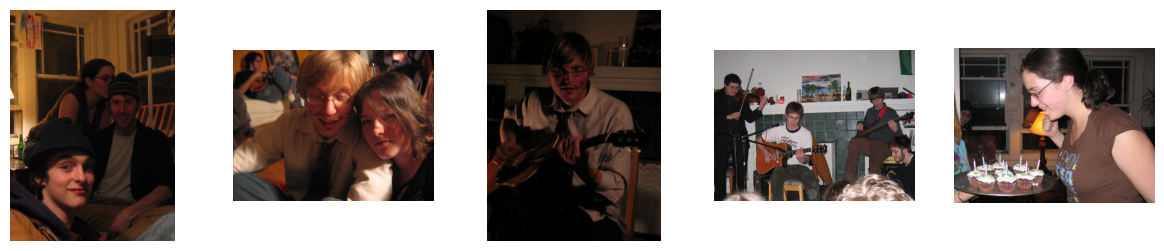

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

trainset = M3ITDataset(dataset)
print('This dataset has {0} images'.format(len(trainset)))

# 1. Datasets need to implement the __len__ method for this to work.
example_index = 102

# 2. Datasets need to implement the  __getitem__ method for this to work.
inst, out  = trainset[example_index]  # Returns image and label.

print('Instruction: ', inst)
print('Output: ', out)

images = trainset.get_images(example_index)

# Create a figure and axis objects
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Plot each image in a separate subplot
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
img = trainset.get_images_PIL(example_index)
print(img)
# Show the plot
plt.show()

In [ ]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch

model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-flan-t5-xl")
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-flan-t5-xl")

config.json:   0%|          | 0.00/7.74k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/140k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

qformer_tokenizer/tokenizer_config.json:   0%|          | 0.00/343 [00:00<?, ?B/s]

qformer_tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

qformer_tokenizer/tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

qformer_tokenizer/added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

(…)former_tokenizer/special_tokens_map.json:   0%|          | 0.00/149 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
device =  "cpu"
model = model.to(device)

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Example transformation sequence
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to Tensor with values in [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for model
])

In [ ]:
#from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
#from PIL import Image

# Define function to process and summarize a single image with context
'''
def summarize_image(image, processor, model, previous_summary, inst_prompt = ""):
  prompt = inst_prompt if inst_prompt else "Based on the previous images, give a short summary of this image."
  prompt += f" {previous_summary}"  # Include previous summary in the prompt
  inputs = processor(images=image, text=prompt, return_tensors="pt")
  outputs = model.generate(**inputs)
  summary = processor.batch_decode(outputs, skip_special_tokens=True)[0]
  return summary
'''

def summarize_image(image, processor, model, previous_summary, inst_prompt= ""):
    prompt = inst_prompt if inst_prompt else "Based on the previous images, give a detailed description of this image."
    prompt += f" {previous_summary}"  # Include previous summary in the prompt
    inputs = processor(images=image, text=prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=100)  # Assuming max length of summary
    decoded_outputs = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    # Find the first period in the generated summary
    period_index = decoded_outputs.find(".")
    if period_index != -1:
        summary = decoded_outputs[:period_index+1]  # Include the period
    else:
        summary = decoded_outputs  # If no period found, use the whole generated text
    return summary

previous_summary = ""
summaries = []
for image in images:
  if previous_summary:
    summary = summarize_image(image, processor, model, previous_summary)
    summaries.append(summary)
  else:
    inst_prompt = inst
    summary = summarize_image(image, processor, model, previous_summary, inst_prompt)
    summaries.append(summary)


# Print the summary for each image
for i, summary in enumerate(summaries):
  print(f"{summary}")


The image depicts a group of people sitting in a living room, with one person sitting on the couch and another person sitting on the chair.
The man and woman in the image are posing for a photo while sitting in a living room.
The man in the image is playing a guitar in a dark room.
The group of people in the room are playing music together.
The woman in the brown shirt is holding a tray of cupcakes for her birthday.
